# TIDAL FIELD EVOLUTION

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.colors as colors
from loadmodules import *

%matplotlib inline

In [36]:
simulation = './Auriga_SC/K12_fiducial/halo_6'
snapshots = [30, 35, 50, 65, 85, 90, 105, 120]

In [49]:
def get_tidal_field_histogram(simulation, snapshot):
    sf = load_subfind(snapshot, dir=simulation+'/output/', hdf5=True, loadonly=['fpos', 'frc2', 'svel', 'flty', 'fnsh', 'slty', 'spos', 'smty', 'ffsh'] )
    s = gadget_readsnap(snapshot, snappath=simulation+'/output/', subfind=sf, hdf5=True, loadonlyhalo=0)
    s.calc_sf_indizes( sf )
    galrad = 0.1 * sf.data['frc2'][0]
    s.select_halo( sf, use_principal_axis=True, use_cold_gas_spin=False, do_rotation=True )

    print('Redshift of the simulation: {:2.2f}'.format(s.redshift))

    gyr = 1e9 * 365.25 * 24 * 3600
    s.parameters['UnitTime_in_s'] = s.parameters['UnitLength_in_cm'] / s.parameters['UnitVelocity_in_cm_per_s']
    s.data['ttij'] *= gyr**2 / s.parameters['UnitTime_in_s']**2

    gasparts = s.data['type'] == 0
    starparts = s.data['age'] > 0.

    TTij_g = s.data['ttij'][gasparts]
    finitemask = np.isfinite(TTij_g)
    TTij_g = TTij_g[finitemask.all(axis=1)]
    r_g = s.r()[gasparts][finitemask.all(axis=1)]
    TTij_s = s.data['ttij'][s.data['type']==4][starparts]
    finitemask = np.isfinite(TTij_s)
    TTij_s = TTij_s[finitemask.all(axis=1)]
    r_s = s.r()[s.data['type']==4][starparts][finitemask.all(axis=1)]

    TT_eig_g = np.zeros((len(TTij_g),3))
    TT_eig_s = np.zeros((len(TTij_s),3))

    TT_eig_g = np.linalg.eigvalsh(TTij_g.reshape(len(TTij_g),3,3))
    TT_eig_g = np.sort(TT_eig_g, axis=1)
    TT_eig_s = np.linalg.eigvalsh(TTij_s.reshape(len(TTij_s),3,3))
    TT_eig_s = np.sort(TT_eig_s, axis=1)

    T_str_g = TT_eig_g[:,2] + 1./3. * np.abs(TT_eig_g[:,0] + TT_eig_g[:,1] + TT_eig_g[:,2])
    T_str_s = TT_eig_s[:,2] + 1./3. * np.abs(TT_eig_s[:,0] + TT_eig_s[:,1] + TT_eig_s[:,2])

    fig, ax = plt.subplots(1, 2 ,figsize=(15,7), sharey=True)
    binx = np.linspace(0, galrad*1e3, 20)
    biny = np.linspace(0,20, 20)
    h = ax[0].hist2d(r_s*1e3, np.log10(T_str_s), bins=(binx, biny), cmap='Greys', norm=colors.LogNorm())
    h = ax[1].hist2d(r_g*1e3, np.log10(T_str_g), bins=(binx, biny), cmap='Greys', norm=colors.LogNorm())

    ax[0].set_ylabel(r'$\log_{10}\rm{T}_{\rm{tid}}$ [Gyr$^{-2}$]', fontsize=14)
    ax[0].set_title('Stars', fontsize=14)
    ax[1].set_title('Gas', fontsize=14)

    fig.supxlabel('Radius [kpc]', fontsize=14)
    fig.suptitle(simulation + ', z = {:.2f}'.format(s.redshift), fontsize=16)
    
    fig.subplots_adjust(wspace=0.)
    fig.subplots_adjust(right=0.9)
    cbar_ax = fig.add_axes([0.92, 0.12, 0.02, 0.78])
    fig.colorbar(h[3], cax=cbar_ax)

    plt.tick_params(labelsize=12)
    plt.show()


galrad= 0.01
Found 1265 stars.
Rotated pos.
Rotated bfld.
Rotated vel.
Redshift of the simulation: 10.92


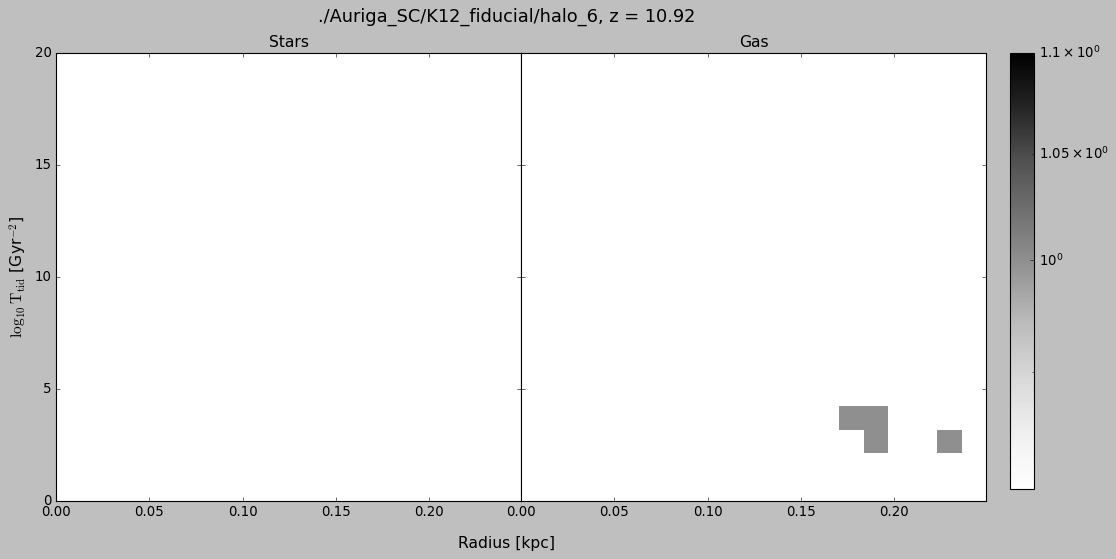

galrad= 0.01
Found 4061 stars.
Rotated pos.
Rotated bfld.
Rotated vel.
Redshift of the simulation: 8.45


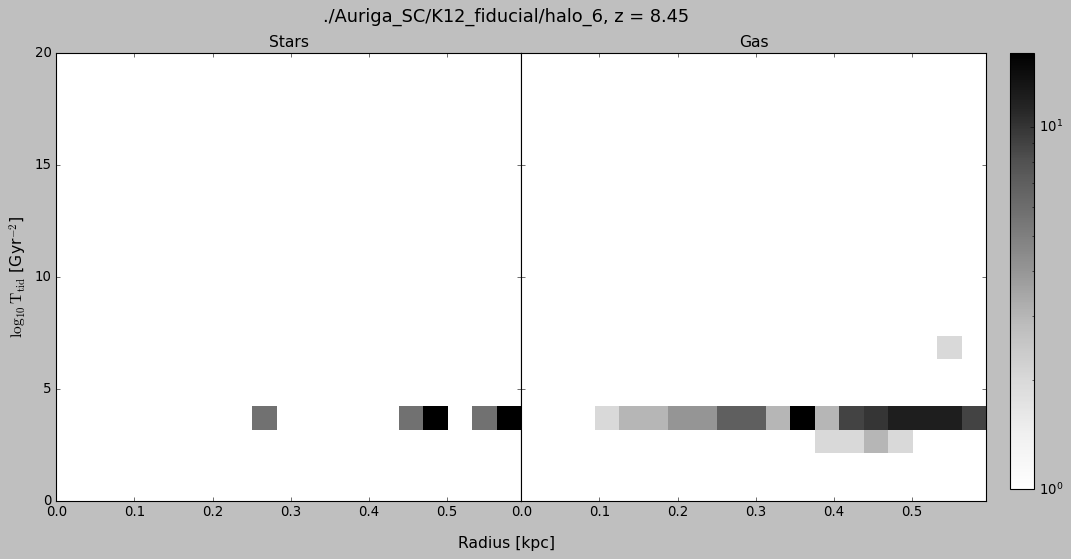

galrad= 0.01
Found 19771 stars.
Rotated pos.
Rotated bfld.
Rotated vel.
Redshift of the simulation: 3.71


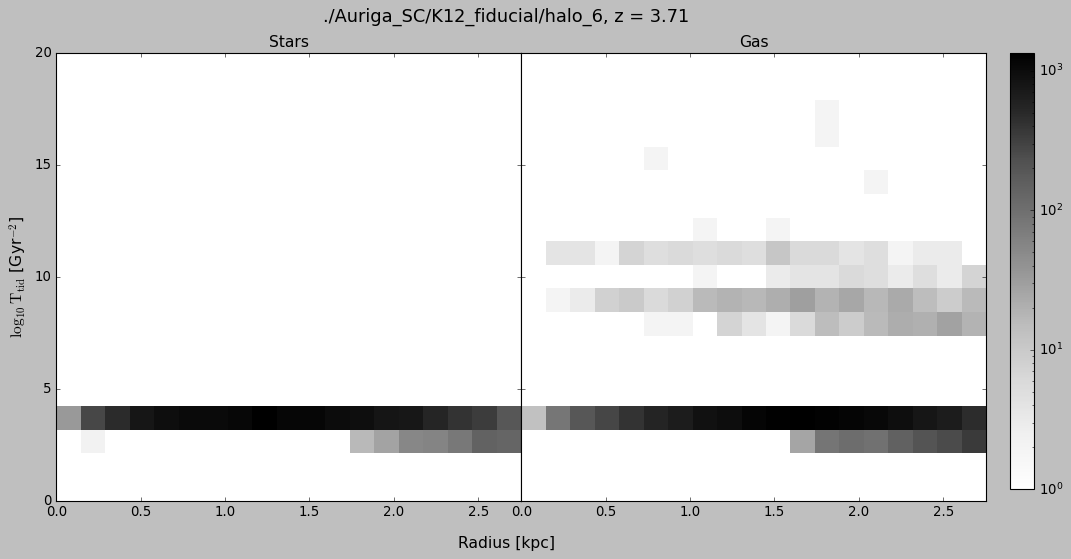

galrad= 0.01
Found 218174 stars.
Rotated pos.
Rotated bfld.
Rotated vel.
Redshift of the simulation: 1.67


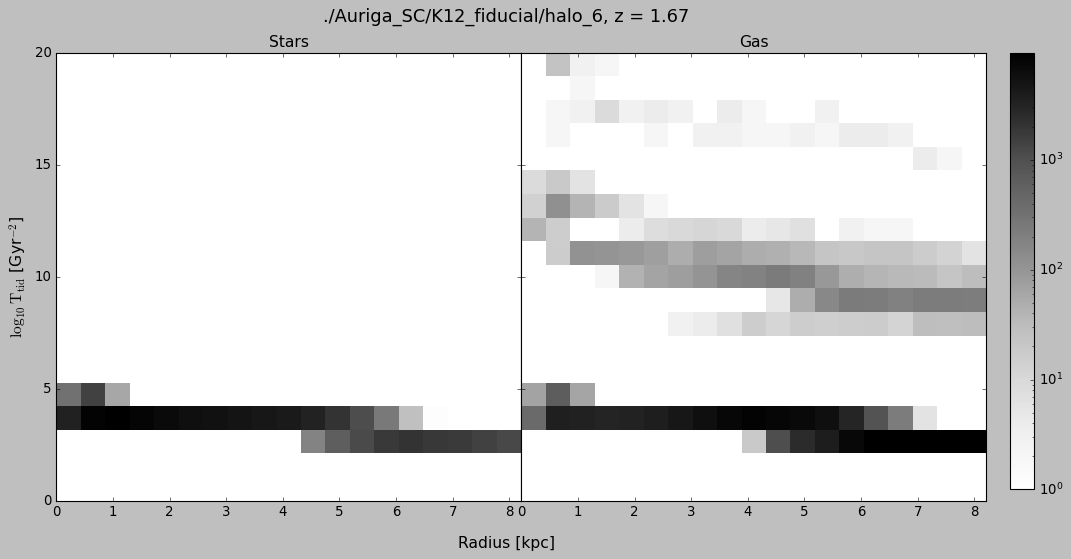

galrad= 0.01486102193593979
Found 712610 stars.
Rotated pos.
Rotated bfld.
Rotated vel.
Redshift of the simulation: 0.76


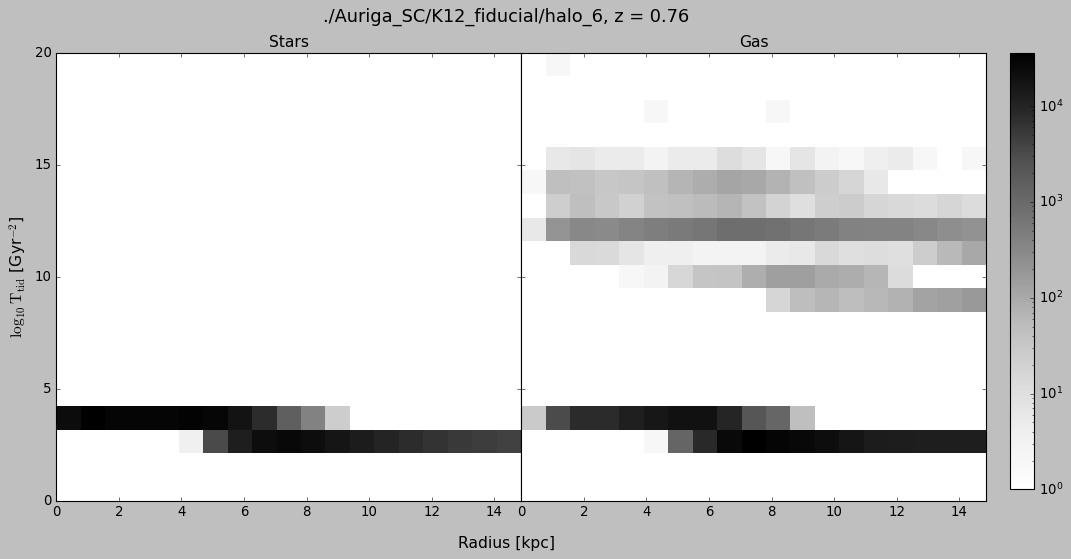

galrad= 0.015797977149486542
Found 858372 stars.
Rotated pos.
Rotated bfld.
Rotated vel.
Redshift of the simulation: 0.62


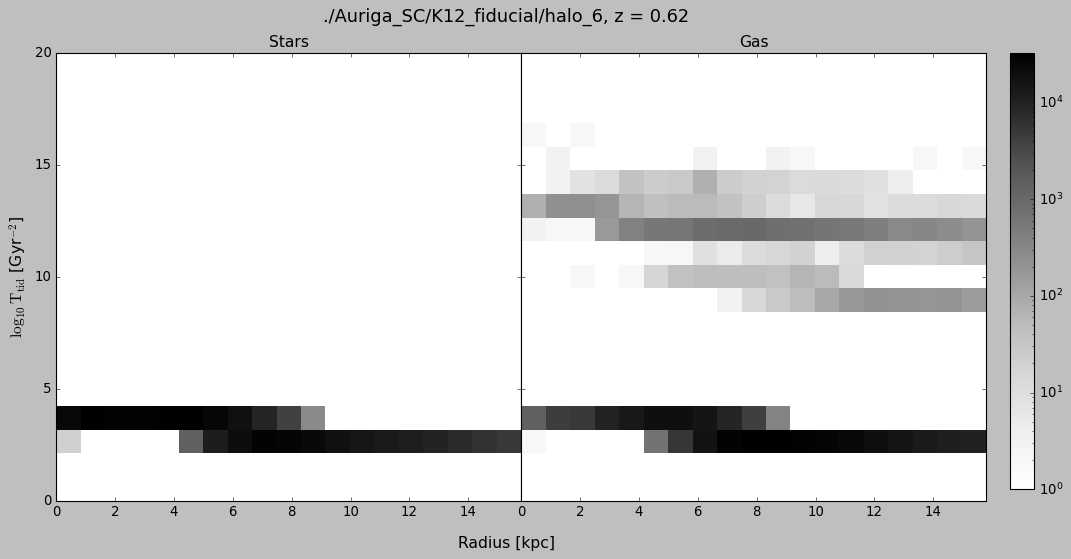

galrad= 0.017978832125663757
Found 1134321 stars.
Rotated pos.
Rotated bfld.
Rotated vel.
Redshift of the simulation: 0.31


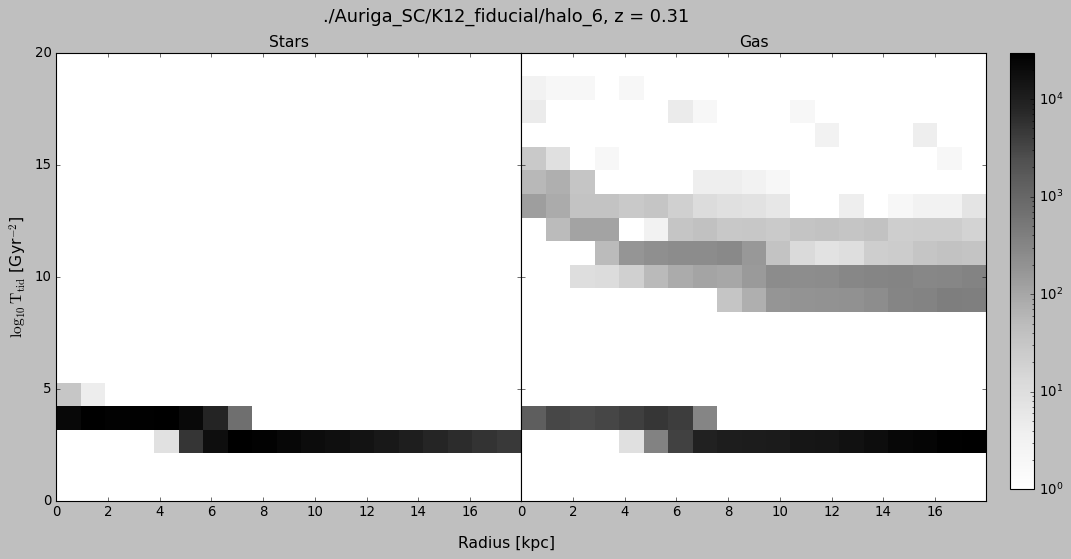

galrad= 0.020717792212963104
Found 1254143 stars.
Rotated pos.
Rotated bfld.
Rotated vel.
Redshift of the simulation: 0.08


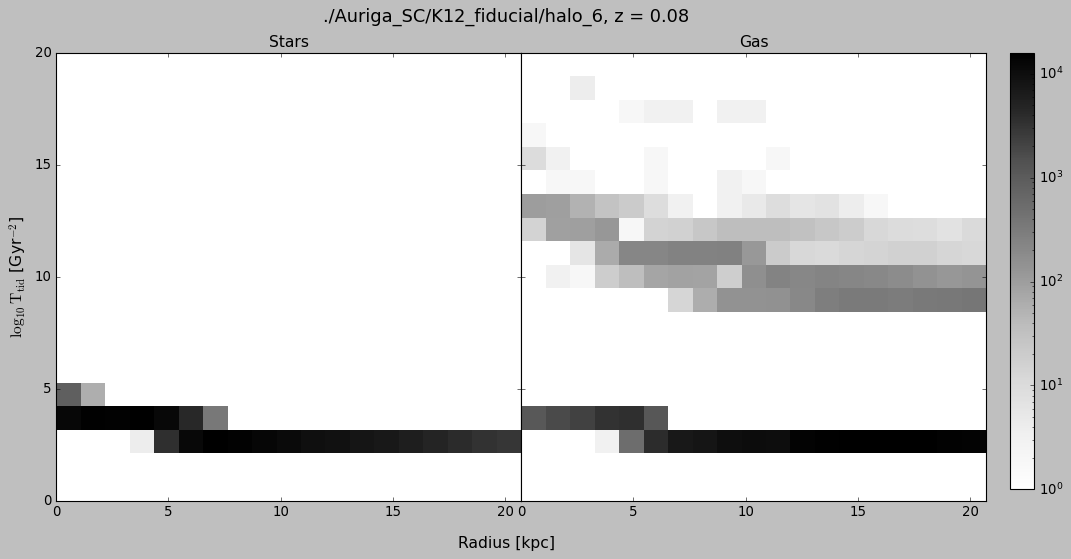

In [50]:
for i in snapshots:
    get_tidal_field_histogram(simulation, i)

In [52]:
import pynbody

s = pynbody.load(simulation + '/output/snapdir_120/snapshot_120')
h = s.halos()
transform = pynbody.analysis.angmom.faceon(h[0])
main = h[0]
s.physical_units()
h.physical_units()
R200 = h[0].properties['Group_R_Crit200']
print('R200 = ', R200)

myr = 1e6 * 365.25 * 24 * 3600
s['TidalTensor'] *= myr**2

# Mask out infinite values in the TidalTensor
finite_mask = np.isfinite(s['TidalTensor']).all(axis=1)
s['Tij'] = np.zeros((len(s),3))
s['Tij'][finite_mask] = np.sort(np.linalg.eigvals((s['TidalTensor'][finite_mask]).reshape(len(s[finite_mask]),3,3)), axis=1)
s['T'] = s['Tij'][:,2] + 1./3. * np.abs(s['Tij'][:,0] + s['Tij'][:,1] + s['Tij'][:,2])
s['Omega'] = np.sqrt(1./3. * np.abs(s['Tij'][:,0] + s['Tij'][:,1] + s['Tij'][:,2]))

/users/aripcont/.local/lib/python3.10/site-packages/pynbody/snapshot/gadgethdf.py:403: UserWarning: Masses are either stored in the header or have another dataset name; assuming the cosmological factor h**-1
  warnings.warn("Masses are either stored in the header or have another dataset name; assuming the cosmological factor %s" % units.h**-1)


R200 =  2.07e+02 kpc


In [53]:
xmin = -0.5
xmax = 1.
ymin = -0.5
ymax = 0.5
zmin = -0.5
zmax = 0.5
mask = (main['x'] < xmax) * (main['x'] > xmin) * (main['y'] < ymax) * (main['y'] > ymin) * (main['z'] < zmax) * (main['z'] > zmin)

/users/aripcont/.local/lib/python3.10/site-packages/pynbody/analysis/halo.py:102: RuntimeWarning: Final sphere is empty; cannot return a velocity. This probably implies something is wrong with the position centre too.
  warnings.warn("Final sphere is empty; cannot return a velocity. This probably implies something is "
/users/aripcont/.local/lib/python3.10/site-packages/pynbody/kdtree/__init__.py:352: RuntimeWarning: 

The particles span a region larger than the specified boxsize; disabling periodicity.

For more information about this warning, see the module documentation for KDTree, 
https://pynbody.readthedocs.io/latest/reference/_autosummary/pynbody.kdtree.KDTree.html
  smx = kdmain.nn_start(self.kdtree, int(nn), self.boxsize)


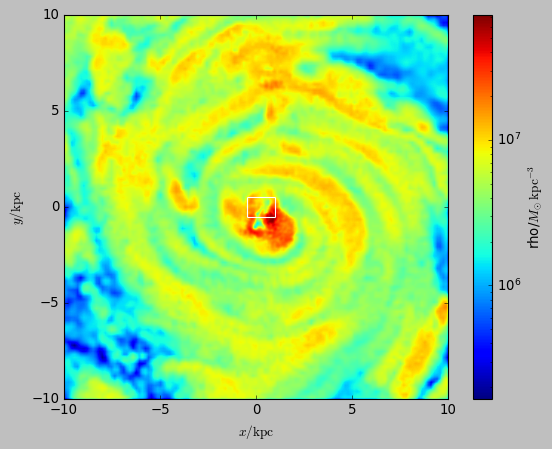

In [54]:
pynbody.plot.sph.faceon_image(main.g, width=20., weight=False)
plt.hlines(ymax, xmin, xmax, color='w')
plt.hlines(ymin, xmin, xmax, color='w')
plt.vlines(xmin, ymin, ymax, color='w')
plt.vlines(xmax, ymin, ymax, color='w')

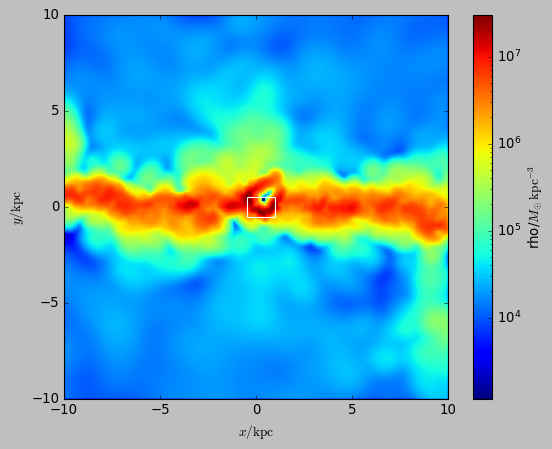

In [55]:
pynbody.plot.sph.sideon_image(main.g, width=20, weight=False)
plt.hlines(zmax, xmin, xmax, color='w')
plt.hlines(zmin, xmin, xmax, color='w')
plt.vlines(xmin, zmin, zmax, color='w')
plt.vlines(xmax, zmin, zmax, color='w')

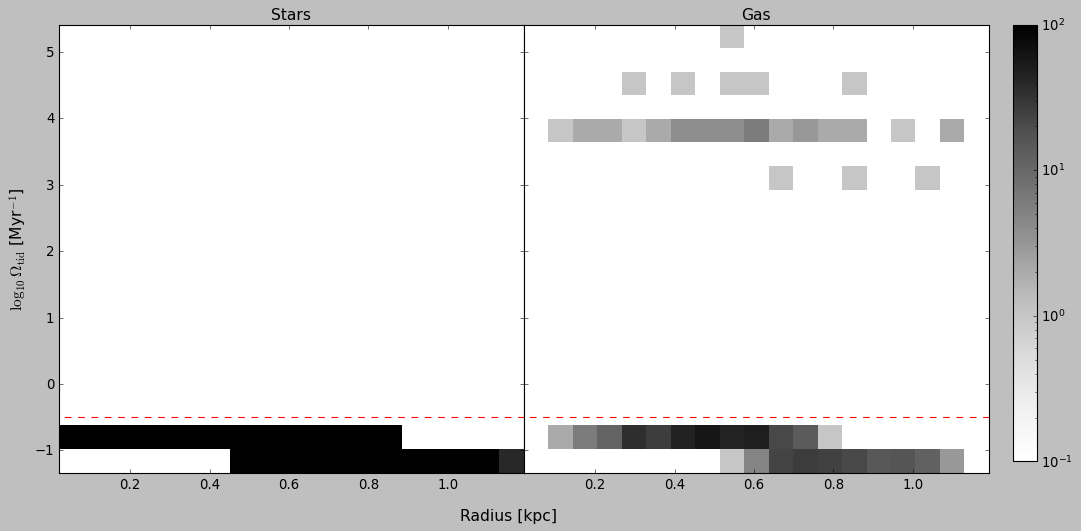

In [56]:
fig, ax = plt.subplots(1, 2 ,figsize=(15,7), sharey=True)
h = ax[0].hist2d(main[mask].s['r'], np.log10(main[mask].s['Omega']), bins=(np.linspace(main[mask]['r'].min(), main[mask]['r'].max(), 20), np.linspace(np.log10((main[mask]['Omega']).min()), np.log10((main[mask]['Omega']).max()), 20)), cmap='Greys', norm=colors.LogNorm(vmin=1e-1, vmax=1e2))
h = ax[1].hist2d(main[mask].g['r'], np.log10(main[mask].g['Omega']), bins=(np.linspace(main[mask]['r'].min(), main[mask]['r'].max(), 20), np.linspace(np.log10((main[mask]['Omega']).min()), np.log10((main[mask]['Omega']).max()), 20)), cmap='Greys', norm=colors.LogNorm(vmin=1e-1, vmax=1e2))

ax[0].hlines(np.log10(0.32), 0, R200.in_units('kpc')/2., color='r', linestyle='--')
ax[1].hlines(np.log10(0.32), 0, R200.in_units('kpc')/2., color='r', linestyle='--')

ax[0].set_ylabel(r'$\log_{10}\Omega_{\rm{tid}}$ [Myr$^{-1}$]', fontsize=14)
ax[0].set_title('Stars', fontsize=14)
ax[1].set_title('Gas', fontsize=14)

fig.supxlabel('Radius [kpc]', fontsize=14)
fig.subplots_adjust(wspace=0.)
fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.92, 0.12, 0.02, 0.78])
fig.colorbar(h[3], cax=cbar_ax)

plt.tick_params(labelsize=12)

In [57]:
mask_gas = (np.log10(main.g['Omega'])>1.) * (main.g['r']<1.)

22.033166140317917 3.8401110764495288 -0.8632069043117045
14.688867144286633 3.8521567634575025 -0.8443209221179294
16.42262563109398 3.849085761953507 -0.8513131283909228
18.72456446290016 3.832720575035567 -0.8651025453693886
28.444865718483925 3.851371621124207 -0.8285353387459259
21.41234464943409 4.617938824460119 -0.8940698589821552
14.688405208289623 4.665252946769054 -0.8499936869696365
14.688686467707157 3.801863473568586 -0.8861212225405943
19.43139359354973 3.860671723325135 -0.8659935110581086
15.579873695969582 3.8522171044995583 -0.8923957831247252
23.224974051117897 3.810154056990012 -0.8991500842456923
11.612548492848873 3.820307081526075 -0.927040230502894
26.48065611720085 3.077335577194244 -1.011343462524461
257.52490758895874 5.36511438801582 -0.9896326309756639
21.412400528788567 3.82332697511168 -0.9332500509789077
12.72081770002842 3.8582071851331574 -0.8311579253537418
18.724316731095314 3.8258958804324323 -0.9643674714021049
23.22482131421566 3.8163953484693494

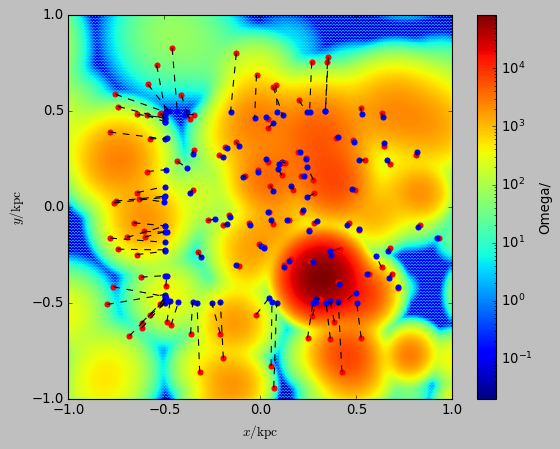

In [63]:
pynbody.plot.sph.faceon_image(main.g, qty='Omega', width=2., weight=False)
for i in range(len(main.g[mask_gas])):
    plt.scatter(main.g['x'][mask_gas][i], main.g['y'][mask_gas][i], color='r')
    rel_pos = main[mask].s['pos'] - main.g[mask_gas]['pos'][i]
    rel_r = np.sum(rel_pos**2, axis=1)**0.5
    min_r = np.argmin(rel_r)
    plt.scatter(main[mask].s['x'][min_r], main[mask].s['y'][min_r], color='b')
    plt.plot([main.g[mask_gas]['x'][i], main[mask].s['x'][min_r]], [main.g[mask_gas]['y'][i], main[mask].s['y'][min_r]], color='k', linestyle='--')
    print(rel_r[min_r]*1e3, np.log10(main.g['Omega'][mask_gas][i]), np.log10(main[mask].s['Omega'][min_r]))

/users/aripcont/.local/lib/python3.10/site-packages/pynbody/analysis/halo.py:102: RuntimeWarning: Final sphere is empty; cannot return a velocity. This probably implies something is wrong with the position centre too.
  warnings.warn("Final sphere is empty; cannot return a velocity. This probably implies something is "


22.03315496444702 3.8401110764495288 -0.8632069043117045
14.688832685351372 3.8521567634575025 -0.8443209221179294
16.422586515545845 3.849085761953507 -0.8513131283909228
18.724562600255013 3.832720575035567 -0.8651025453693886
28.444815427064896 3.851371621124207 -0.8285353387459259
21.412350237369537 4.617938824460119 -0.8940698589821552
14.688446186482906 4.665252946769054 -0.8499936869696365
14.688707888126373 3.801863473568586 -0.8861212225405943
19.43139359354973 3.860671723325135 -0.8659935110581086
15.579849481582642 3.8522171044995583 -0.8923957831247252
23.224962875247 3.810154056990012 -0.8991500842456923
11.612548492848873 3.820307081526075 -0.927040230502894
26.480630040168762 3.077335577194244 -1.011343462524461
257.52490758895874 5.36511438801582 -0.9896326309756639
21.412383764982224 3.82332697511168 -0.9332500509789077
12.720823287963867 3.8582071851331574 -0.8311579253537418
18.72432790696621 3.8258958804324323 -0.9643674714021049
23.22482131421566 3.8163953484693494

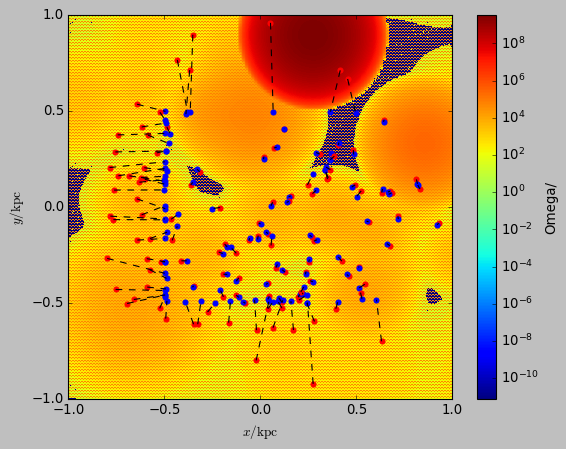

In [62]:
pynbody.plot.sph.sideon_image(main.g, qty='Omega', width=2., weight=False)
for i in range(len(main.g[mask_gas])):
    rel_pos = main[mask].s['pos'] - main.g[mask_gas]['pos'][i]
    rel_r = np.sum(rel_pos**2, axis=1)**0.5
    min_r = np.argmin(rel_r)
    plt.plot([main.g[mask_gas]['x'][i], main[mask].s['x'][min_r]], [main.g[mask_gas]['z'][i], main[mask].s['z'][min_r]], color='k', linestyle='--')
    plt.scatter(main.g['x'][mask_gas][i], main.g['z'][mask_gas][i], color='r')
    plt.scatter(main[mask].s['x'][min_r], main[mask].s['z'][min_r], color='b')
    print(rel_r[min_r]*1e3, np.log10(main.g['Omega'][mask_gas][i]), np.log10(main[mask].s['Omega'][min_r]))